# CLASSIFICATION WITH SUPPORT VECTOR MACHINE (SVM)
by ChunkDevs (Group 1)

In machine learning, Support Vector Machines (SVMs) are supervised max-margin models with associated learning algorithms that analyze data for classification and regression analysis. they can perform both linear and non-linear classification.

This model is largely in used in Machine Learning and Natural Language Processing, thanks to its fastness in training and implicit regularization.   

In this notebook, we set up a pipeline for Support Vector Classifier (SVC) with feature extraction, selection, weighting and hyperparameter tuning.

Firstly, we initialize the SVC model and preprocesses the text data using scikit-learn's `CountVectorizer` which converts text into a numerical matrix while filtering out words that appear in fewer than 5 documents. Next, `SelectKBest` with mutual information is employed to select the top 5000 most informative features from the vectorized data. Then, `TfidfTransformer` normalizes the feature matrix based on the Term Frequency-Inverse Document Frequency (TF-IDF) scheme, enhancing the importance of rare terms.

After the gridsearch with 5 fold cross-validation, we will use the best models with their parameters to predict to the test-set and show the results.

In [59]:
import sys
import os

directory = os.getcwd().split(os.path.sep)
root_index = directory.index("V_HLT")
root_path = os.path.sep.join(directory[:root_index+1])

sys.path.append(root_path)

In [60]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from _chunkdevs.models import ChunkDevs_GridTrainer, ModelHandler
from _chunkdevs.data_functions import *

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# DATA LOADING

In [61]:
dev_path = os.path.join(root_path, "data", "processed", "english_tweets_dev_set.csv")
dev = pd.read_csv(dev_path, encoding="utf-8", skipinitialspace=True)

test_path = os.path.join(root_path, "data", "processed", "english_tweets_test_set.csv")
test = pd.read_csv(test_path, encoding="utf-8", skipinitialspace=True)

In [62]:
# defining the path route to save/ load models
path_models = os.path.join(root_path, 'outputs', 'models')

RANDOM_STATE = 42

k_fold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

<div style="font-size: 16px">


Same value of `RANDOM_STATE` as the other notebooks to guarantee the reproducibility of the results, splitting the dev set into 5 folds during the crossvalidation and shuffling enabled
<br>
</div>

# BINARY CLASSIFICATION TASK

As the other notebooks, we will search for the best model whit the highest f1 score

In [63]:
X_dev_bin = dev['tweet_text_cleaned'].values
y_dev_bin = dev['cyberbullying_type_bin'].values
X_test_bin = test['tweet_text'].values
y_test_bin = test['cyberbullying_type_bin'].values

## PIPELINE FOR THE MODEL INPUT 

In [64]:
model = SVC()
vectorizer = CountVectorizer(min_df=5)
selector = SelectKBest(mutual_info_classif, k=5000)
weighter = TfidfTransformer()


# Feature extraction
X_dev_bin = vectorizer.fit_transform(X_dev_bin)
X_test_bin = vectorizer.transform(X_test_bin)

# Feature selection
X_dev_bin = selector.fit(X_dev_bin, y_dev_bin).transform(X_dev_bin)
X_test_bin = selector.transform(X_test_bin)

# Weighting
X_dev_bin = weighter.fit(X_dev_bin).transform(X_dev_bin)
X_test_bin = weighter.transform(X_test_bin)


param_grid = {
    'kernel': ['linear', 'sigmoid', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'max_iter': [100000]
}

After the devset and testset transformation, for hyperparameter optimization, a grid search is performed over different kernels (`linear`, `sigmoid`, `poly`, `rbf`), regularization parameters (`c`) and a maximum number of iterations (`max_iter`).

## MODEL SELECTION

GRIDTRAINER CLASS

After the gridsearch, the class shows the best hyperparameters

In [ ]:
# Classification for binary task
'''
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="f1_weighted", cv=k_fold, n_jobs=-1)
best_model_svc_countvect_bin = trainer.train(X_dev_bin, y_dev_bin)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")
'''

# Best Parameters: {'C': 10, 'kernel': 'rbf', 'max_iter': 100000}

## MODEL LOADING (for **not repeating the gridsearch**)

Since the greadsearch can take a long time, we leave our model to be loaded, with best parameters:
- 'C' = 10, amplitude of the margin
- 'kernel' = 'rbf', kernel used
- 'max_iter'= 100000 numbeer of maximum iterations

In [66]:
Handler = ModelHandler(path_models)
best_model_svc_countvect_bin = Handler.load_model("svc_countvect_bin")
best_model_svc_countvect_bin

SVC(C=10, max_iter=100000)

## TESTING PHASE

In [67]:
y_pred_bin = best_model_svc_countvect_bin.predict(X_test_bin)
report = classification_report(y_pred= y_pred_bin, y_true= y_test_bin)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.45      0.53       487
           1       0.90      0.95      0.92      2435

    accuracy                           0.87      2922
   macro avg       0.77      0.70      0.72      2922
weighted avg       0.85      0.87      0.86      2922



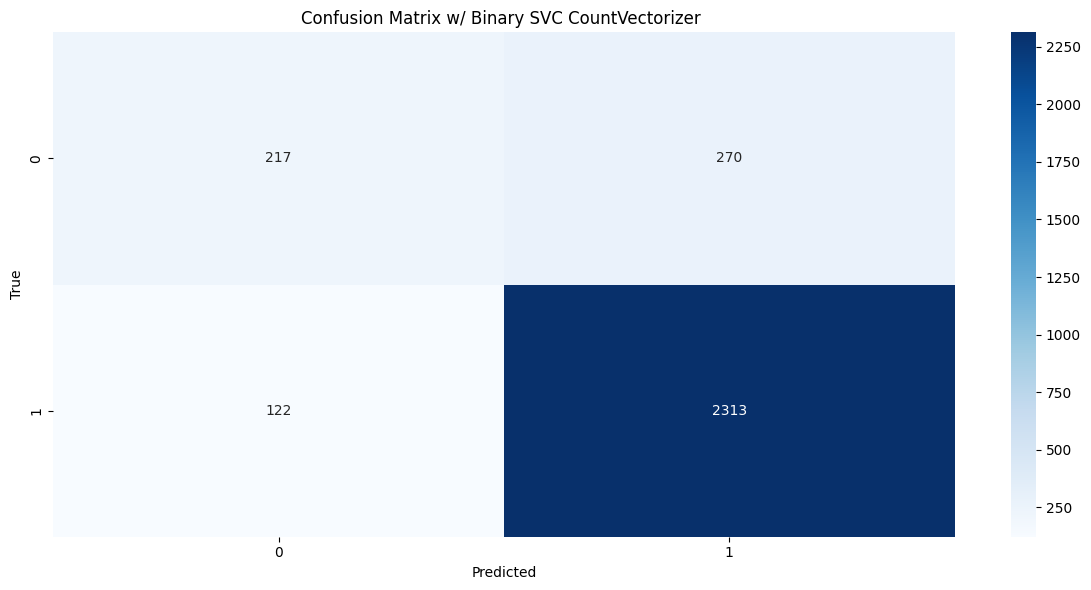

In [68]:
matrix = confusion_matrix(y_pred= y_pred_bin, y_true=y_test_bin)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ Binary SVC CountVectorizer ')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', '2_advanced_models', '0_cm_svc_countvect_bin.png'))
plt.show()

### RESULTS SAVING

Saving the results to the appripriate 

In [69]:
save_path = os.path.join(root_path, 'outputs', 'reports', '4_svc_countvect.txt')

if type(best_model_svc_countvect_bin) == ChunkDevs_GridTrainer:
   
    best_model_svc_countvect_bin.save_results(X_test_bin, y_test_bin, save_path)

else:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Write the report contents to a file
        with open(save_path, 'a') as file:
            file.write(f"Model: 4_svc_countvect\n")
            file.write(f"Best Parameters: {best_model_svc_countvect_bin.get_params()}\n")
            file.write(f"Classification Report:\n{report}\n")

        # Print a confirmation message.
        print(f"Report saved to {save_path}") 

Report saved to c:\Users\ASUS\OneDrive - University of Pisa\Human language technologies\V_HLT\outputs\reports\4_svc_countvect.txt


# MULTICLASSIFICATION TASK  

We repeat the same procedure as before, ando look for the model with the best accuracy

In [70]:
X_dev_multi = dev['tweet_text_cleaned'].values
y_dev_multi = dev['cyberbullying_type_multi'].values
X_test_multi = test['tweet_text'].values
y_test_multi = test['cyberbullying_type_multi'].values

## PIPELINE FOR THE MODEL INPUT

In [71]:
model = SVC()
vectorizer = CountVectorizer(min_df=5)
selector = SelectKBest(mutual_info_classif, k=5000)
weighter = TfidfTransformer()


# Feature extraction
X_train_multi = vectorizer.fit_transform(X_dev_multi)
X_test_multi = vectorizer.transform(X_test_multi)

# Feature selection
X_train_multi = selector.fit(X_train_multi, y_dev_multi).transform(X_train_multi)
X_test_multi = selector.transform(X_test_multi)

# Weighting
X_train_multi = weighter.fit(X_train_multi).transform(X_train_multi)
X_test_multi = weighter.transform(X_test_multi)


param_grid = {
    'kernel': ['linear', 'sigmoid', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'max_iter': [100000]
}

## MODEL SELECTION

In [72]:
# classification for multiclass task

'''
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="accuracy", cv=k_fold, n_jobs=-1)
best_model_svc_countvect_multi = trainer.train(X_train_multi, y_dev_multi)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")
'''

'\ntrainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="accuracy", cv=k_fold, n_jobs=-1)\nbest_model_svc_countvect_multi = trainer.train(X_train_multi, y_dev_multi)\nbest_params = trainer.get_best_params()\nprint(f"Best Parameters: {best_params} \n")\n'

## MODEL LOADING (for **not repeating the gridsearch**)


Since the greadsearch can take a long time, we leave our model to be loaded, with best parameters:
- 'C' = 1, amplitude of the margin
- 'kernel' = 'rbf', kernel used
- 'max_iter'= 100000 numbeer of maximum iterations

In [73]:
model_path = os.path.join(root_path, 'outputs', 'models')
Handler = ModelHandler(model_path)
best_model_svc_countvect_multi = Handler.load_model("svc_countvect_multi")
best_model_svc_countvect_multi

SVC(C=1, max_iter=100000)

## TESTING PHASE

In [74]:
y_pred_multi = best_model_svc_countvect_multi.predict(X_test_multi)
report = classification_report(y_pred= y_pred_multi, y_true=y_test_multi)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       487
           1       0.98      0.98      0.98       487
           2       0.95      0.80      0.87       487
           3       0.61      0.57      0.59       487
           4       0.60      0.76      0.67       487
           5       0.96      0.93      0.95       487

    accuracy                           0.83      2922
   macro avg       0.84      0.83      0.84      2922
weighted avg       0.84      0.83      0.84      2922



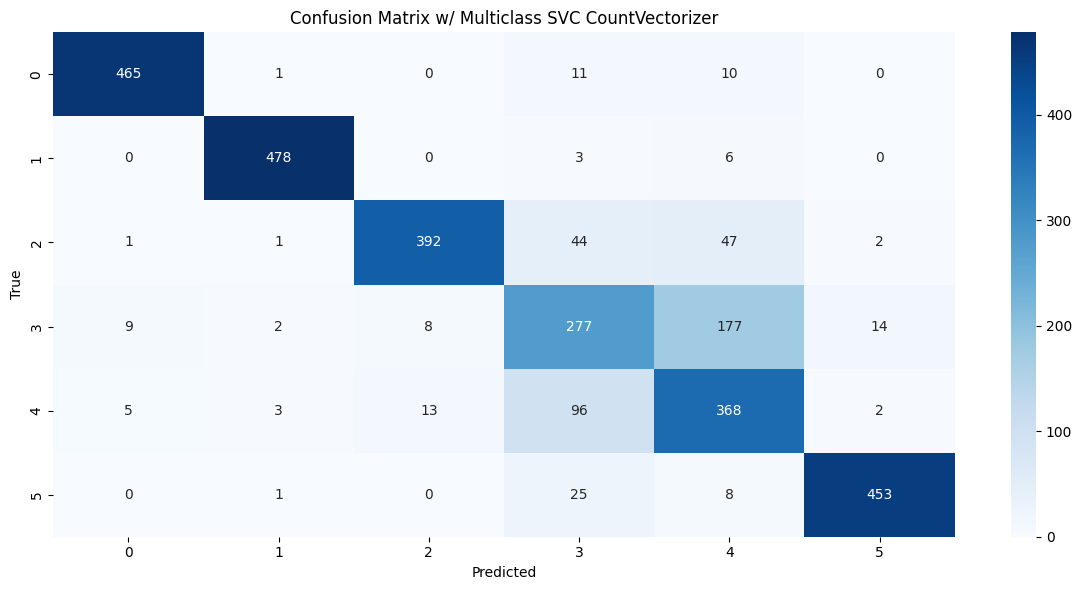

In [75]:
matrix = confusion_matrix(y_pred= y_pred_multi, y_true=y_test_multi)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ Multiclass SVC CountVectorizer')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', '2_advanced_models', '1_cm_svc_countvect_multi.png'))
plt.show()

### RESULTS SAVING

Saving the results to the appripriate 

In [76]:
save_path = os.path.join(root_path, 'outputs', 'reports', '4_svc_countvect.txt')

if type(best_model_svc_countvect_multi) == ChunkDevs_GridTrainer:
   
    best_model_svc_countvect_multi.save_results(X_test_bin, y_test_bin, save_path)

else:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Write the report contents to a file
        with open(save_path, 'a') as file:
            file.write(f"Model: 4_svc_countvect\n")
            file.write(f"Best Parameters: {best_model_svc_countvect_multi.get_params()}\n")
            file.write(f"Classification Report:\n{report}\n")

        # Print a confirmation message.
        print(f"Report saved to {save_path}")

Report saved to c:\Users\ASUS\OneDrive - University of Pisa\Human language technologies\V_HLT\outputs\reports\4_svc_countvect.txt


# MODEL SAVING

Saving the models to the appropriate folder

In [77]:
# saving of the best models after grid search
handler = ModelHandler(path_models)


models = {
    "svc_countvect_bin" : best_model_svc_countvect_bin,
    "svc_countvect_multi" : best_model_svc_countvect_multi
}

handler.save_models(models)

--------------------------------------------------------------------------------------------------------------------------------------------------------
| Save model 'svc_countvect_bin' to c:\Users\ASUS\OneDrive - University of Pisa\Human language technologies\V_HLT\outputs\models\svc_countvect_bin.pkl |
--------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------
| Save model 'svc_countvect_multi' to c:\Users\ASUS\OneDrive - University of Pisa\Human language technologies\V_HLT\outputs\models\svc_countvect_multi.pkl |
------------------------------------------------------------------------------------------------------------------------------------------------------------


<div style="font-size: 22px;">   

Giving the conclusions, the SVM model follows with precision scores of 63% for non-cyberbullying and 90% for cyberbullying, and recall scores of 49% and 94%. The F1-scores here are also robust at 55% and 92% for the binary class. As the other models, it suffers from the false flagging of the not cyberbullying class. 

In the multiclass task, SVM has an accuracy of 83%, showcasing their robustness and
consistency in performance, but often confusing the not cyberbullying tweets with the other cyberbullying class.

<br></div>
